## **Pip install packages**

In [34]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [49]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# **Classification Question PART A**

### **Model Imports and Basic Preprocessing**

In [46]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
import multiprocessing as mp
import statistics

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [47]:
df = pd.read_csv('/Users/abhishekvaidyanathan/Desktop/NNDL/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [48]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [49]:
print("Number of categories: ", df['label'].nunique())
print("The categories are: ", df["label"].unique())

Number of categories:  10
The categories are:  ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [50]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [51]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


## **QUESTION 1**

### **QUESTION 1a)** ###

In [52]:
def feed_forward_network():
  hidden_neurons = 16

  model = Sequential()
  model.add(Dense(hidden_neurons, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train, y_train,
                      batch_size=1,
                      epochs=50,
                      verbose=2,
                      use_multiprocessing=False,
                      validation_data=(X_test, y_test))
  return history

In [53]:
feed_forward_network_results = feed_forward_network()

Epoch 1/50
700/700 - 1s - loss: 2.1661 - accuracy: 0.2171 - val_loss: 1.7915 - val_accuracy: 0.3433
Epoch 2/50
700/700 - 1s - loss: 1.7777 - accuracy: 0.3486 - val_loss: 1.5567 - val_accuracy: 0.4300
Epoch 3/50
700/700 - 0s - loss: 1.5044 - accuracy: 0.4471 - val_loss: 1.3715 - val_accuracy: 0.5167
Epoch 4/50
700/700 - 1s - loss: 1.4312 - accuracy: 0.4571 - val_loss: 1.2849 - val_accuracy: 0.5400
Epoch 5/50
700/700 - 0s - loss: 1.2978 - accuracy: 0.5429 - val_loss: 1.2318 - val_accuracy: 0.5533
Epoch 6/50
700/700 - 1s - loss: 1.2299 - accuracy: 0.5543 - val_loss: 1.1676 - val_accuracy: 0.5733
Epoch 7/50
700/700 - 1s - loss: 1.2010 - accuracy: 0.5657 - val_loss: 1.1182 - val_accuracy: 0.5833
Epoch 8/50
700/700 - 0s - loss: 1.1176 - accuracy: 0.6086 - val_loss: 1.0895 - val_accuracy: 0.5967
Epoch 9/50
700/700 - 0s - loss: 1.0778 - accuracy: 0.6014 - val_loss: 1.0490 - val_accuracy: 0.6067
Epoch 10/50
700/700 - 0s - loss: 1.0726 - accuracy: 0.5929 - val_loss: 1.0301 - val_accuracy: 0.6233

### **QUESTION 1b)** ###

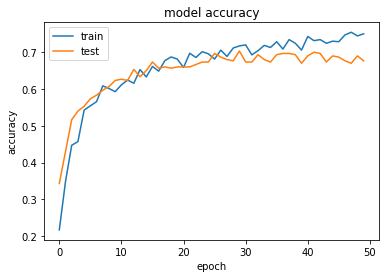

In [54]:
plt.figure(1)
plt.plot(feed_forward_network_results.history['accuracy'])
plt.plot(feed_forward_network_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 1c)** ###

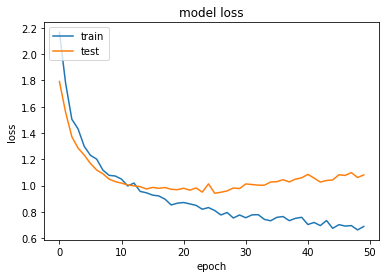

In [55]:
plt.figure(2)
plt.plot(feed_forward_network_results.history['loss'])
plt.plot(feed_forward_network_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **QUESTION 2**

### **QUESTION 2a)** ###

In [62]:
class time_for_batch(Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time()-self.starttime)
        
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [59]:
def K_fold_cross_validation(no_folds,no_epochs,batch_size,X,Y,hidden_neurons,epoch_times_dict):
  print("Model training for:")
  print("Batch size",batch_size)
  print("Number of epcohs:" ,no_epochs)
  print("No folds used for k-fold cross validation:", no_folds)
  print("")

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []
  for train_index, test_index in kf.split(X_train):
      X_train_K, X_test_K = X[train_index], X[test_index]
      y_train_K, y_test_K = Y[train_index], Y[test_index]

      model = Sequential()
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(10, activation='softmax'))

      model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      tb = time_for_batch()
      te = time_for_epoch()

      history = model.fit(X_train_K, y_train_K,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=2,
                          use_multiprocessing=False,
                          callbacks = [tb, te],
                          validation_data=(X_test_K, y_test_K))
      epoch_times_dict[batch_size] = te.times
      print("")
      history_results.append(history)

  return history_results


In [69]:
Batch_sizes = [1,4,8,16,32, 64]
model_results = {}
epoch_times_dict = {}
for size in Batch_sizes:
  history = K_fold_cross_validation(3,50,size,X_train,y_train,16,epoch_times_dict)
  model_results[size] = history

Model training for:
Batch size 1
Number of epcohs: 50
No folds used for k-fold cross validation: 3

Epoch 1/50
466/466 - 1s - loss: 2.2115 - accuracy: 0.2511 - val_loss: 1.8106 - val_accuracy: 0.3889
Epoch 2/50
466/466 - 0s - loss: 1.7463 - accuracy: 0.3691 - val_loss: 1.5446 - val_accuracy: 0.4744
Epoch 3/50
466/466 - 0s - loss: 1.5777 - accuracy: 0.4185 - val_loss: 1.4405 - val_accuracy: 0.5427
Epoch 4/50
466/466 - 0s - loss: 1.4570 - accuracy: 0.4764 - val_loss: 1.2986 - val_accuracy: 0.5812
Epoch 5/50
466/466 - 0s - loss: 1.3512 - accuracy: 0.5107 - val_loss: 1.2403 - val_accuracy: 0.6154
Epoch 6/50
466/466 - 0s - loss: 1.2523 - accuracy: 0.5558 - val_loss: 1.2024 - val_accuracy: 0.5940
Epoch 7/50
466/466 - 0s - loss: 1.2512 - accuracy: 0.5343 - val_loss: 1.1754 - val_accuracy: 0.6111
Epoch 8/50
466/466 - 0s - loss: 1.1679 - accuracy: 0.5751 - val_loss: 1.1376 - val_accuracy: 0.6111
Epoch 9/50
466/466 - 0s - loss: 1.1317 - accuracy: 0.6009 - val_loss: 1.1456 - val_accuracy: 0.6026


In [63]:
model_results_accuracy = {}
model_results_validation_accuracy = {}
model_results_loss = {}
model_results_validation_loss = {}
for key in model_results:
    model_results_accuracy[key] = []
    model_results_validation_accuracy[key] = []
    model_results_loss[key] = []
    model_results_validation_loss[key] = []
    for results in model_results[key]:
        model_results_accuracy[key].append(results.history['accuracy'])
        model_results_validation_accuracy[key].append(results.history['val_accuracy'])
        model_results_loss[key].append(results.history['loss'])
        model_results_validation_loss[key].append(results.history['val_loss'])

In [64]:
for key in model_results_accuracy:
    model_results_accuracy[key] = np.asarray(model_results_accuracy[key]).mean(axis=0)
    model_results_validation_accuracy[key] = np.asarray(model_results_validation_accuracy[key]).mean(axis=0)
    model_results_loss[key] = np.asarray(model_results_loss[key]).mean(axis=0)
    model_results_validation_loss[key] = np.asarray(model_results_validation_loss[key]).mean(axis=0)

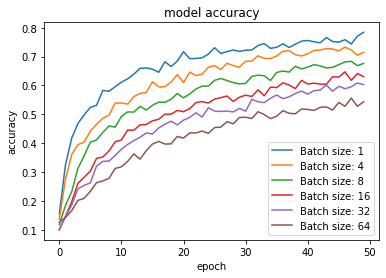

In [65]:
plt.figure(1)
key_array = []
for key in model_results_accuracy:
    plt.plot(model_results_accuracy[key])
    key_array.append("Batch size: "+str(key))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

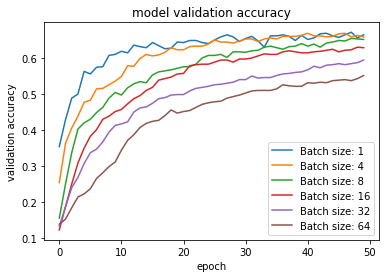

In [66]:
plt.figure(2)
key_array = []
for key in model_results_validation_accuracy:
    plt.plot(model_results_validation_accuracy[key])
    key_array.append("Batch size: "+str(key))
plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

### **QUESTION 2b)** ###

In [74]:
median_times = []
for key in epoch_times_dict:
  epoch_times_dict[key] = statistics.median(epoch_times_dict[key])
  median_times.append(epoch_times_dict[key])

median_times_dataframe = pd.DataFrame()
median_times_dataframe['Batch_sizes'] = Batch_sizes
median_times_dataframe['median_epoch_times'] = median_times
median_times_dataframe

,Batch_sizes,median_epoch_times
0,1,0.364487
1,4,0.132861
2,8,0.076064
3,16,0.051180
4,32,0.038097
5,64,0.027399


### **QUESTION 2c)** ##

In [75]:
model_results_final_accuracy = {}
model_results_final_validation_accuracy = {}
model_results_final_loss = {}
model_results_final_validation_loss = {}
for key in model_results:
    model_results_final_accuracy[key] = max(model_results_accuracy[key])
    model_results_final_loss[key] = min(model_results_loss[key])
    model_results_final_validation_accuracy[key] = max(model_results_validation_accuracy[key])
    model_results_final_validation_loss[key] = min(model_results_validation_loss[key])

In [76]:
accuracies = []
validation_accuracies = []
loss = []
validation_loss = []
for key in model_results:
    accuracies.append(model_results_final_accuracy[key])
    validation_accuracies.append(model_results_final_validation_accuracy[key])
    loss.append(model_results_final_loss[key])
    validation_loss.append(model_results_final_validation_loss[key])

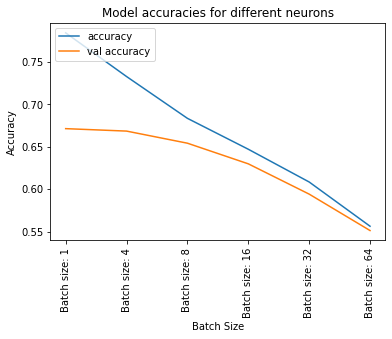

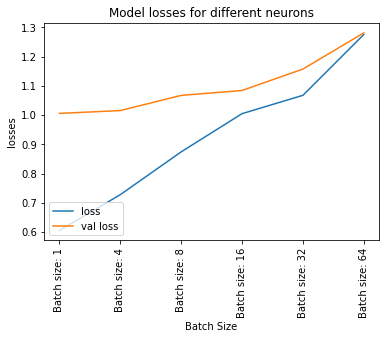

In [78]:
plt.figure(1)
plt.plot(key_array,accuracies,label="accuracy")
plt.plot(key_array,validation_accuracies,label="val accuracy")
plt.title('Model accuracies for different neurons')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(['accuracy', 'val accuracy'], loc='upper left') 
plt.show()

plt.figure(2)
plt.plot(key_array,loss,label="loss")
plt.plot(key_array,validation_loss,label="val loss")
plt.title('Model losses for different neurons')
plt.xlabel('Batch Size')
plt.ylabel('losses')
plt.xticks(rotation=90) 
plt.legend(['loss', 'val loss'], loc='lower left') 
plt.show()

From the above plots it can be deduces that the model with batch size 4 seems to perfomr considerably better when compared to other models. 

### **QUESTION 2d)** ###

Answered in the report

### **QUESTION 2e)** ###

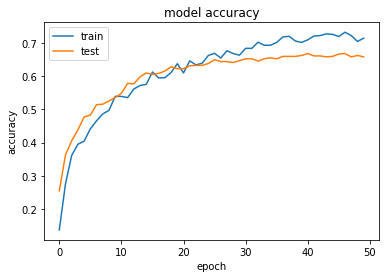

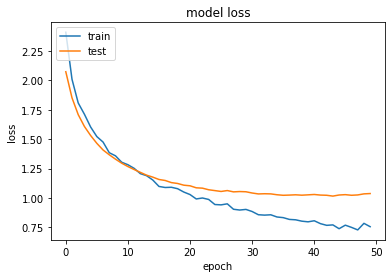

In [79]:
plt.figure(1)
plt.plot(model_results_accuracy[4])
plt.plot(model_results_validation_accuracy[4])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(model_results_loss[4])
plt.plot(model_results_validation_loss[4])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **QUESTION 3**

### **QUESTION 3a)** ###

In [80]:
def K_fold_cross_validation_neurons(no_folds,no_epochs,batch_size,X,Y,hidden_neurons,epoch_times_dict):
  print("Model training for:")
  print("Number of neurons",hidden_neurons)
  print("Number of epcohs:" ,no_epochs)
  print("No folds used for k-fold cross validation:", no_folds)
  print("")

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []
  for train_index, test_index in kf.split(X_train):
      X_train_K, X_test_K = X[train_index], X[test_index]
      y_train_K, y_test_K = Y[train_index], Y[test_index]

      model = Sequential()
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(10, activation='softmax'))

      model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      tb = time_for_batch()
      te = time_for_epoch()

      history = model.fit(X_train_K, y_train_K,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=2,
                          use_multiprocessing=False,
                          callbacks = [tb, te],
                          validation_data=(X_test_K, y_test_K))
      epoch_times_dict[hidden_neurons] = te.times
      print("")
      history_results.append(history)
  return history_results

In [81]:
number_of_neurons = [8, 16, 32, 64]
epoch_times_dict_neurons = {}
model_results_neurons = {}
for neurons in number_of_neurons:
  history = K_fold_cross_validation_neurons(3,50,4,X_train,y_train,neurons,epoch_times_dict_neurons)
  model_results_neurons[neurons] = history

Model training for:
Number of neurons 8
Number of epcohs: 50
No folds used for k-fold cross validation: 3

Epoch 1/50
117/117 - 1s - loss: 2.5043 - accuracy: 0.1266 - val_loss: 2.1585 - val_accuracy: 0.2350
Epoch 2/50
117/117 - 0s - loss: 2.1382 - accuracy: 0.2146 - val_loss: 1.9308 - val_accuracy: 0.3675
Epoch 3/50
117/117 - 0s - loss: 2.0490 - accuracy: 0.2554 - val_loss: 1.8208 - val_accuracy: 0.4017
Epoch 4/50
117/117 - 0s - loss: 1.9451 - accuracy: 0.2940 - val_loss: 1.7488 - val_accuracy: 0.4274
Epoch 5/50
117/117 - 0s - loss: 1.8541 - accuracy: 0.3283 - val_loss: 1.6876 - val_accuracy: 0.4487
Epoch 6/50
117/117 - 0s - loss: 1.8014 - accuracy: 0.3498 - val_loss: 1.6415 - val_accuracy: 0.4615
Epoch 7/50
117/117 - 0s - loss: 1.7802 - accuracy: 0.3498 - val_loss: 1.6022 - val_accuracy: 0.4615
Epoch 8/50
117/117 - 0s - loss: 1.7738 - accuracy: 0.3541 - val_loss: 1.5650 - val_accuracy: 0.4744
Epoch 9/50
117/117 - 0s - loss: 1.6894 - accuracy: 0.3970 - val_loss: 1.5427 - val_accuracy: 

In [82]:
model_results_neurons_accuracy = {}
model_results_neurons_validation_accuracy = {}
model_results_neurons_loss = {}
model_results_neurons_validation_loss = {}
for key in model_results_neurons:
    model_results_neurons_accuracy[key] = []
    model_results_neurons_validation_accuracy[key] = []
    model_results_neurons_loss[key] = []
    model_results_neurons_validation_loss[key] = []
    for results in model_results_neurons[key]:
        model_results_neurons_accuracy[key].append(results.history['accuracy'])
        model_results_neurons_validation_accuracy[key].append(results.history['val_accuracy'])
        model_results_neurons_loss[key].append(results.history['loss'])
        model_results_neurons_validation_loss[key].append(results.history['val_loss'])

In [83]:
for key in model_results_neurons_accuracy:
    model_results_neurons_accuracy[key] = np.asarray(model_results_neurons_accuracy[key]).mean(axis=0)
    model_results_neurons_validation_accuracy[key] = np.asarray(model_results_neurons_validation_accuracy[key]).mean(axis=0)
    model_results_neurons_loss[key] = np.asarray(model_results_neurons_loss[key]).mean(axis=0)
    model_results_neurons_validation_loss[key] = np.asarray(model_results_neurons_validation_loss[key]).mean(axis=0)

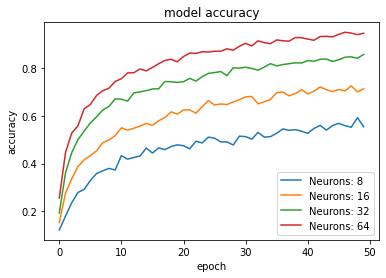

In [84]:
plt.figure(1)
key_array = []
for key in model_results_neurons_accuracy:
    plt.plot(model_results_neurons_accuracy[key])
    key_array.append("Neurons: "+str(key))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

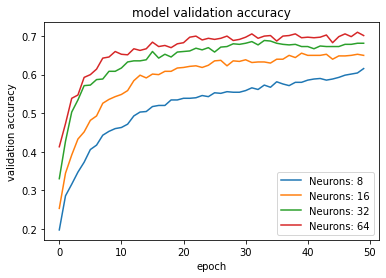

In [85]:
plt.figure(2)
key_array = []
for key in model_results_neurons_validation_accuracy:
    plt.plot(model_results_neurons_validation_accuracy[key])
    key_array.append("Neurons: "+str(key))
plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

### **QUESTION 3b)** ###

In [86]:
model_results_neurons_final_accuracy = {}
model_results_neurons_final_validation_accuracy = {}
model_results_neurons_final_loss = {}
model_results_neurons_final_validation_loss = {}
for key in model_results_neurons:
    model_results_neurons_final_accuracy[key] = max(model_results_neurons_accuracy[key])
    model_results_neurons_final_loss[key] = min(model_results_neurons_loss[key])
    model_results_neurons_final_validation_accuracy[key] = max(model_results_neurons_validation_accuracy[key])
    model_results_neurons_final_validation_loss[key] = min(model_results_neurons_validation_loss[key])

In [87]:
accuracies_neurons = []
validation_accuracies_neurons = []
loss_neurons = []
validation_loss_neurons = []
for key in model_results_neurons:
    accuracies_neurons.append(model_results_neurons_final_accuracy[key])
    validation_accuracies_neurons.append(model_results_neurons_final_validation_accuracy[key])
    loss_neurons.append(model_results_neurons_final_loss[key])
    validation_loss_neurons.append(model_results_neurons_final_validation_loss[key])

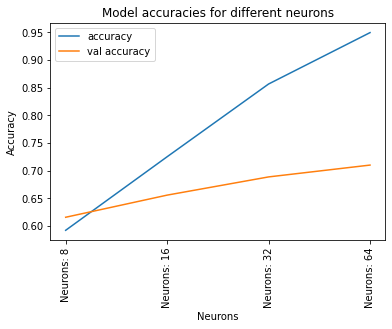

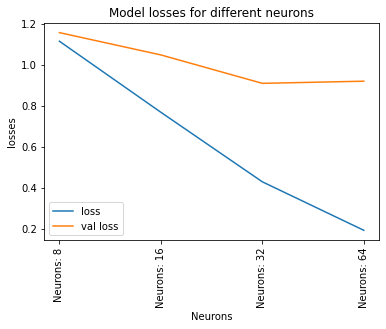

In [88]:
plt.figure(1)
plt.plot(key_array,accuracies_neurons,label="accuracy")
plt.plot(key_array,validation_accuracies_neurons,label="val accuracy")
plt.title('Model accuracies for different neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(['accuracy', 'val accuracy'], loc='upper left') 
plt.show()

plt.figure(2)
plt.plot(key_array,loss_neurons,label="loss")
plt.plot(key_array,validation_loss_neurons,label="val loss")
plt.title('Model losses for different neurons')
plt.xlabel('Neurons')
plt.ylabel('losses')
plt.xticks(rotation=90) 
plt.legend(['loss', 'val loss'], loc='lower left') 
plt.show()

Using number of neurons 16 gives best possible model since the validation loss is low as well as the model has a validation accuracy of 72% with minimal overfitting when compared to other models using different number of neurons.

### **QUESTION 3c)** ###

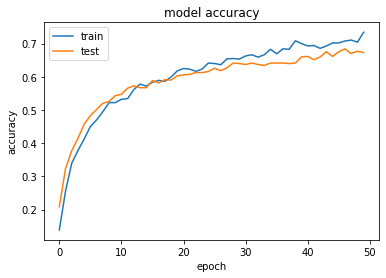

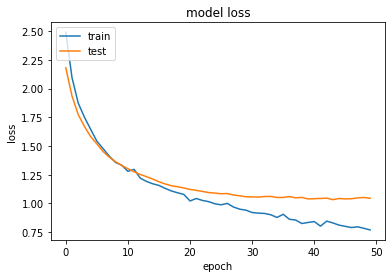

In [102]:
plt.figure(1)
plt.plot(model_results_neurons_accuracy[16])
plt.plot(model_results_neurons_validation_accuracy[16])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(model_results_neurons_loss[16])
plt.plot(model_results_neurons_validation_loss[16])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 3d)** ###

number of epochs can be tuned. Changing the dropout layer. WE ca also consider changing the train test split as well as using shuffling when implementing K-Fold.

## **QUESTION 4**

In [96]:
def three_layer_K_fold_cross_validation(no_folds,no_epochs,batch_size,X,Y,hidden_neurons):

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(X_train):
      X_train_K, X_test_K = X[train_index], X[test_index]
      y_train_K, y_test_K = Y[train_index], Y[test_index]

      model = Sequential()
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(10, activation='softmax'))

      model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      tb = time_for_batch()
      te = time_for_epoch()

      history = model.fit(X_train_K, y_train_K,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=2,
                          use_multiprocessing=False,
                          callbacks = [tb, te],
                          validation_data=(X_test_K, y_test_K))
      return history

In [97]:
three_layer_network_results = three_layer_K_fold_cross_validation(3,50,4,X_train,y_train,16)

Epoch 1/50
117/117 - 2s - loss: 2.4062 - accuracy: 0.1052 - val_loss: 2.2519 - val_accuracy: 0.2009
Epoch 2/50
117/117 - 0s - loss: 2.2378 - accuracy: 0.1695 - val_loss: 2.1483 - val_accuracy: 0.3162
Epoch 3/50
117/117 - 0s - loss: 2.1109 - accuracy: 0.2511 - val_loss: 2.0246 - val_accuracy: 0.3846
Epoch 4/50
117/117 - 0s - loss: 2.0175 - accuracy: 0.3112 - val_loss: 1.9004 - val_accuracy: 0.3974
Epoch 5/50
117/117 - 0s - loss: 1.9317 - accuracy: 0.2961 - val_loss: 1.7786 - val_accuracy: 0.4145
Epoch 6/50
117/117 - 0s - loss: 1.8211 - accuracy: 0.3627 - val_loss: 1.6829 - val_accuracy: 0.4444
Epoch 7/50
117/117 - 0s - loss: 1.8024 - accuracy: 0.3605 - val_loss: 1.5961 - val_accuracy: 0.4744
Epoch 8/50
117/117 - 0s - loss: 1.7202 - accuracy: 0.3863 - val_loss: 1.5409 - val_accuracy: 0.4872
Epoch 9/50
117/117 - 0s - loss: 1.6801 - accuracy: 0.3927 - val_loss: 1.4787 - val_accuracy: 0.5000
Epoch 10/50
117/117 - 0s - loss: 1.6443 - accuracy: 0.3991 - val_loss: 1.4613 - val_accuracy: 0.5043

### **QUESTION 4a)**

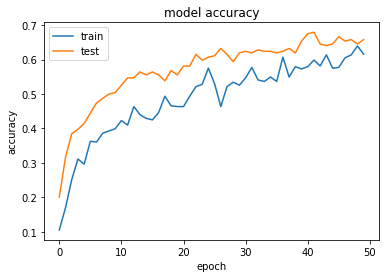

In [99]:
plt.figure(1)
plt.plot(three_layer_network_results.history['accuracy'])
plt.plot(three_layer_network_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 4b)**

In [92]:
print("The results for the model with neurons size "+str(16)+" and batch size "+str(1))
print("train accuracy: ",max(three_layer_network_results.history['accuracy']))
print("validation accuracy: ",max(three_layer_network_results.history['val_accuracy']))
print("train loss: ",min(three_layer_network_results.history['loss']))
print("validation loss: ",min(three_layer_network_results.history['val_loss']))

The results for the model with neurons size 16 and batch size 1
train accuracy:  0.6888412237167358
validation accuracy:  0.692307710647583
train loss:  0.8776381611824036
validation loss:  1.09613835811615


From the above model results we can infer that the model with three layers i.e., with two hidden layers doesn't preform as good as the model with two layers, one hidden layer since both the validation accuracy and the validation loss or not as good as the model with two layers. 

## **QUESTION 5**


### **QUESTION 5a)**

In [100]:
def two_layer_network_without_dropout():
    hidden_neurons = 16

    model = Sequential()
    model.add(Dense(hidden_neurons, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    tb = time_for_batch()
    te = time_for_epoch()

    history = model.fit(X_train, y_train,
                        batch_size=4,
                        epochs=50,
                        verbose=2,
                        use_multiprocessing=False,
                        callbacks = [tb, te],
                        validation_data=(X_test, y_test))
    return history

In [101]:
two_layer_network_without_dropout_results = two_layer_network_without_dropout()

Epoch 1/50
175/175 - 1s - loss: 2.0778 - accuracy: 0.2971 - val_loss: 1.7890 - val_accuracy: 0.4000
Epoch 2/50
175/175 - 0s - loss: 1.6238 - accuracy: 0.4586 - val_loss: 1.5450 - val_accuracy: 0.4767
Epoch 3/50
175/175 - 0s - loss: 1.4005 - accuracy: 0.5200 - val_loss: 1.4229 - val_accuracy: 0.5167
Epoch 4/50
175/175 - 0s - loss: 1.2581 - accuracy: 0.5586 - val_loss: 1.3328 - val_accuracy: 0.5333
Epoch 5/50
175/175 - 0s - loss: 1.1514 - accuracy: 0.6000 - val_loss: 1.2805 - val_accuracy: 0.5600
Epoch 6/50
175/175 - 0s - loss: 1.0661 - accuracy: 0.6300 - val_loss: 1.2444 - val_accuracy: 0.5533
Epoch 7/50
175/175 - 0s - loss: 1.0004 - accuracy: 0.6671 - val_loss: 1.2064 - val_accuracy: 0.5700
Epoch 8/50
175/175 - 0s - loss: 0.9412 - accuracy: 0.6714 - val_loss: 1.1831 - val_accuracy: 0.5867
Epoch 9/50
175/175 - 0s - loss: 0.8904 - accuracy: 0.7014 - val_loss: 1.1585 - val_accuracy: 0.5767
Epoch 10/50
175/175 - 0s - loss: 0.8450 - accuracy: 0.7229 - val_loss: 1.1314 - val_accuracy: 0.5933

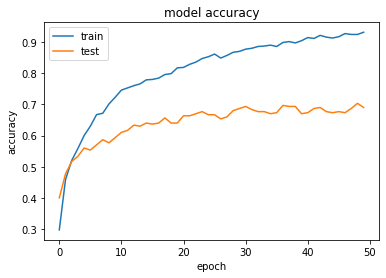

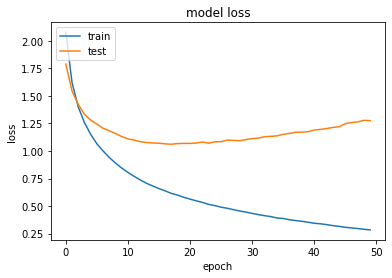

In [102]:
plt.figure(1)
plt.plot(two_layer_network_without_dropout_results.history['accuracy'])
plt.plot(two_layer_network_without_dropout_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(two_layer_network_without_dropout_results.history['loss'])
plt.plot(two_layer_network_without_dropout_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
print("The results for the model with neurons size "+str(16)+" and batch size "+str(1))
print("train accuracy: ",max(two_layer_network_without_dropout_results.history['accuracy']))
print("validation accuracy: ",max(two_layer_network_without_dropout_results.history['val_accuracy']))
print("train loss: ",min(two_layer_network_without_dropout_results.history['loss']))
print("validation loss: ",min(two_layer_network_without_dropout_results.history['val_loss']))

The results for the model with neurons size 16 and batch size 1
train accuracy:  0.9314285516738892
validation accuracy:  0.70333331823349
train loss:  0.2836439907550812
validation loss:  1.0614348649978638


### **QUESTION 5b)**

Removing dropouts resulted in the model overfitting on the training data. This will result in the model not performing well on new data while performing very well on train data. 

### **QUESTION 5c)** 

Answered in the report

# **Regresssion Question PART B**

### **Package imports and Preprocessing**

In [104]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [105]:
from tensorflow import keras
from tensorflow.keras import layers,optimizers
import keras.backend as K
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [106]:
import pandas as pd
df = pd.read_csv('/Users/abhishekvaidyanathan/Desktop/NNDL/hdb_price_prediction.csv .csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [107]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## **QUESTION 1**

### **QUESTION 1a)**

In [108]:
train_data = df[df['year']<=2020]
test_data = df[df['year']>2020]

In [109]:
train_data.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [110]:
test_data.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
87371,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0
87372,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0
87373,1,2021,216 ANG MO KIO AVENUE 1,Ang Mo Kio,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0
87374,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0
87375,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0


In [111]:
print("train data shape:",train_data.shape)
print("test data shape:", test_data.shape)

train data shape: (87371, 13)
test data shape: (16723, 13)


### **QUESTION 1b)**

In [112]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_data)
test_ds = dataframe_to_dataset(test_data)

In [113]:
batch_size = 128
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [114]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [115]:
# Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month",dtype="int64")

# Categorical feature encoded as string
storey_range = keras.Input(shape=(1,), name="storey_range",dtype="string")
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,),name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,),name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,),name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,),name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,),name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,),name="floor_area_sqm")

all_inputs = [
    month,
    storey_range,
    flat_model_type,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

# # Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# # String categorical features
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

# # Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn,"dist_to_nearest_stn",train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby,"dist_to_dhoby",train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality,"degree_centrality",train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality,"eigenvector_centrality",train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years,"remaining_lease_years",train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm",train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded
    ]
)

In [117]:
def regression_model():
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, 
            tf.keras.losses.MeanSquaredError(), 
            metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/best_epoch_question1_checkpoint.tf',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[model_checkpoint_callback])

    return [history,model]


### **QUESTION 1c)**

In [118]:
regression_model_results = regression_model()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 4s 3ms/step - loss: 187583053824.0000 - mean_squared_error: 187583053824.0000 - root_mean_squared_error: 433108.5938 - r2_score: -7.0660 - val_loss: 171209719808.0000 - val_mean_squared_error: 171209719808.0000 - val_root_mean_squared_error: 413774.9688 - val_r2_score: -5.7161
Epoch 2/100
683/683 [==============================] - 2s 2ms/step - loss: 67385896960.0000 - mean_squared_error: 67385896960.0000 - root_mean_squared_error: 259587.9375 - r2_score: -1.8876 - val_loss: 39828561920.0000 - val_mean_squared_error: 39828561920.0000 - val_root_mean_squared_error: 199570.9375 - val_r2_score: -0.5504
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 10821044224.0000 - mean_squared_error: 10821044224.0000 - root_mean_squared_error: 104024.2500 - r2_score: 0.5415 - val_loss: 11012547584.0000 - val_mean_squared_error: 11012547584.0000 - val_root_mean_squared_error: 104940.6875 - val_r2_score: 0.5746
Epoch 4/100
683/683 [==

### **QUESTION 1d)**

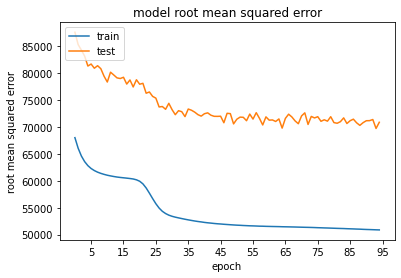

In [124]:
plt.figure(1)
plt.plot(regression_model_results[0].history['root_mean_squared_error'][5:])
plt.plot(regression_model_results[0].history['val_root_mean_squared_error'][5:])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.xticks([x for x in range(5,100,10)])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 1e)**

In [125]:
def epoch_with_lowest_test_error(removed_feature_model):
    epoch_number = np.argmin(removed_feature_model.history['val_loss'])
    val_r2_value = removed_feature_model.history['val_r2_score'][epoch_number]
    r2_value = removed_feature_model.history['r2_score'][epoch_number]

    print("The training epoch with lowest test loss is: ",epoch_number+1)
    print("The values for train r2: ",r2_value)
    print("The value for validation r2: ",val_r2_value)

In [126]:
epoch_with_lowest_test_error(regression_model_results[0])

The training epoch with lowest test loss is:  99
The values for train r2:  0.8883054256439209
The value for validation r2:  0.8095741271972656


In [127]:
print("The model results :")
print("train loss: ",min(regression_model_results[0].history['loss']))
print("validation loss: ",min(regression_model_results[0].history['val_loss']))
print("train MSE: ",min(regression_model_results[0].history['mean_squared_error']))
print("validation MSE: ",min(regression_model_results[0].history['val_mean_squared_error']))
print("train RMSE: ",min(regression_model_results[0].history['root_mean_squared_error']))
print("validation RMSE: ",min(regression_model_results[0].history['val_root_mean_squared_error']))
print("train r2 value: ",max(regression_model_results[0].history['r2_score']))
print("validation r2 value: ",max(regression_model_results[0].history['val_r2_score']))

The model results :
train loss:  2587019520.0
validation loss:  4864011776.0
train MSE:  2587019520.0
validation MSE:  4864011776.0
train RMSE:  50862.75
validation RMSE:  69742.46875
train r2 value:  0.8886514902114868
validation r2 value:  0.8095741271972656


### **QUESTION 1f)**

In [128]:
regression_model_results[1].load_weights("/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/best_epoch_question1_checkpoint.tf")

In [129]:
predictions = regression_model_results[1].predict(test_ds)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


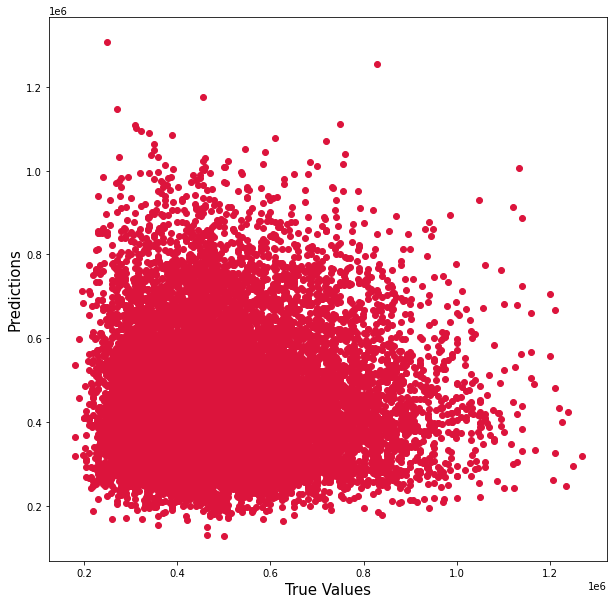

In [130]:
plt.figure(figsize=(10,10))
plt.scatter(np.concatenate([y for x, y in test_ds], axis=0), predictions, c='crimson')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
plt.show()

## **QUESTION 2**

### **QUESTION 2a)**

In [133]:
num_categories_month = df['month'].nunique()
num_categories_storey_range = df['storey_range'].nunique()
num_categories_falt_model_type = df['flat_model_type'].nunique()

print("NUmber of categories of month: ",num_categories_month)
print("Number of categories of storey range: ",num_categories_storey_range)
print("NUmber of categories of flat model type: ",num_categories_falt_model_type)


NUmber of categories of month:  12
Number of categories of storey range:  17
NUmber of categories of flat model type:  43


In [139]:
def regression_model_embedding_layer():
    # x = layers.Dense(81, activation="relu")(all_features)
    # x = layers.Embedding(81,81//2)(x)
    # output = layers.Dense(1, activation="linear")(x)
    # model = keras.Model(all_inputs, output)
    # opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    # model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    # keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #     filepath='/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/checkpoint.tf',
    #     save_weights_only=True,
    #     monitor='val_accuracy',
    #     mode='max',
    #     save_best_only=True)
    # history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[model_checkpoint_callback])

    month_x = layers.Embedding(num_categories_month,num_categories_month//2)(month_encoded)
    month_x = layers.Flatten()(month_x)
    storey_range_x = layers.Embedding(num_categories_storey_range,num_categories_storey_range//2)(storey_range_encoded)
    storey_range_x = layers.Flatten()(storey_range_x)
    flat_model_type_x = layers.Embedding(num_categories_falt_model_type,num_categories_falt_model_type//2)(flat_model_type_encoded)
    flat_model_type_x = layers.Flatten()(flat_model_type_x)
    x = layers.concatenate([month_x,storey_range_x,flat_model_type_x,dist_to_nearest_stn_encoded,dist_to_dhoby_encoded,degree_centrality_encoded,eigenvector_centrality_encoded,remaining_lease_years_encoded,floor_area_sqm_encoded])
    x = layers.Dense(10,activation="relu")(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/checkpoint.tf',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[model_checkpoint_callback])

    return [history,model]

### **QUESTION 2b)**

In [140]:
regression_model_embedding_results = regression_model_embedding_layer()

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 6s 4ms/step - loss: 36577640448.0000 - mean_squared_error: 36577640448.0000 - root_mean_squared_error: 191252.8125 - r2_score: -0.5564 - val_loss: 28966668288.0000 - val_mean_squared_error: 28966668288.0000 - val_root_mean_squared_error: 170195.9688 - val_r2_score: -0.1154
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 14142695424.0000 - mean_squared_error: 14142695424.0000 - root_mean_squared_error: 118923.0625 - r2_score: 0.4010 - val_loss: 13265823744.0000 - val_mean_squared_error: 13265823744.0000 - val_root_mean_squared_error: 115177.3594 - val_r2_score: 0.4886
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 8674880512.0000 - mean_squared_error: 8674880512.0000 - root_mean_squared_error: 93139.0391 - r2_score: 0.6299 - val_loss: 11166156800.0000 - val_mean_squared_error: 11166156800.0000 - val_root_mean_squared_error: 105670.0391 - val_r2_score: 0.5678
Epoch 4/100
683/683 [===========

### **QUESTION 2c)**

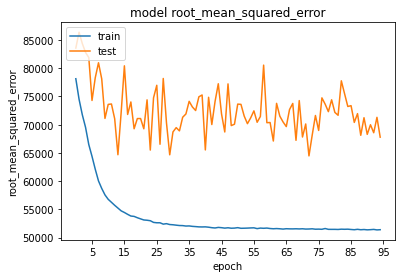

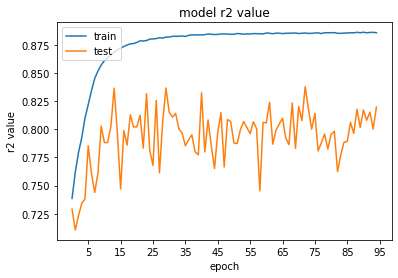

In [141]:
plt.figure(1)
plt.plot(regression_model_embedding_results[0].history['root_mean_squared_error'][5:])
plt.plot(regression_model_embedding_results[0].history['val_root_mean_squared_error'][5:])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.xticks([x for x in range(5,100,10)])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(regression_model_embedding_results[0].history['r2_score'][5:])
plt.plot(regression_model_embedding_results[0].history['val_r2_score'][5:])
plt.title('model r2 value')
plt.ylabel('r2 value')
plt.xlabel('epoch')
plt.xticks([x for x in range(5,100,10)])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [142]:
epoch_with_lowest_test_error(regression_model_embedding_results[0])

The training epoch with lowest test loss is:  78
The values for train r2:  0.8855916261672974
The value for validation r2:  0.8379086852073669


In [143]:
print("The model results when the feature "+str(key)+" is removed")
print("train loss: ",min(regression_model_embedding_results[0].history['loss']))
print("validation loss: ",min(regression_model_embedding_results[0].history['val_loss']))
print("train MSE: ",min(regression_model_embedding_results[0].history['mean_squared_error']))
print("validation MSE: ",min(regression_model_embedding_results[0].history['val_mean_squared_error']))
print("train RMSE: ",min(regression_model_embedding_results[0].history['root_mean_squared_error']))
print("validation RMSE: ",min(regression_model_embedding_results[0].history['val_root_mean_squared_error']))
print("train r2 value: ",max(regression_model_embedding_results[0].history['r2_score']))
print("validation r2 value: ",max(regression_model_embedding_results[0].history['val_r2_score']))

The model results when the feature 64 is removed
train loss:  2638814720.0
validation loss:  4157416192.0
train MSE:  2638814720.0
validation MSE:  4157416192.0
train RMSE:  51369.39453125
validation RMSE:  64478.02734375
train r2 value:  0.8863106369972229
validation r2 value:  0.8379086852073669


## **QUESTION 3**

### **QUESTION3a)**

In [149]:
def regression_model_embedding_layer_early_stopping():
    x = layers.Dense(81, activation="relu")(all_features)
    x = layers.Embedding(81,81//2)(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[callback])

    return [history,model]

In [150]:
regression_model_early_stopping = regression_model_embedding_layer_early_stopping()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 6s 4ms/step - loss: 188928770048.0000 - mean_squared_error: 188928770048.0000 - root_mean_squared_error: 434659.2500 - r2_score: -659.3713 - val_loss: 178354847744.0000 - val_mean_squared_error: 178354847744.0000 - val_root_mean_squared_error: 422320.8750 - val_r2_score: -564.1132
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 77601275904.0000 - mean_squared_error: 77601275904.0000 - root_mean_squared_error: 278569.9375 - r2_score: -268.8468 - val_loss: 57108381696.0000 - val_mean_squared_error: 57108381696.0000 - val_root_mean_squared_error: 238973.6094 - val_r2_score: -178.1701
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 27499730944.0000 - mean_squared_error: 27499730944.0000 - root_mean_squared_error: 165830.3906 - r2_score: -93.2803 - val_loss: 31192344576.0000 - val_mean_squared_error: 31192344576.0000 - val_root_mean_squared_error: 176613.5312 - val_r2_score: -96.5435
Epoch 4/100

In [151]:
print("The training loss for the model: ",min(regression_model_early_stopping[0].history['loss']))
print("The validation loss for the model: ",min(regression_model_early_stopping[0].history['val_loss']))
print("The mean squared error for the model: ",min(regression_model_early_stopping[0].history['mean_squared_error']))
print("The validaton mean squared error for the model: ",min(regression_model_early_stopping[0].history['val_mean_squared_error']))
print("The root squared error for the model: ",min(regression_model_early_stopping[0].history['root_mean_squared_error']))
print("The validation root squared error for the model: ",min(regression_model_early_stopping[0].history['val_root_mean_squared_error']))
print("The r2 score for the model: ",min(regression_model_early_stopping[0].history['r2_score']))
print("The validation r2 score for the model: ",min(regression_model_early_stopping[0].history['val_r2_score']))

The training loss for the model:  23745564672.0
The validation loss for the model:  29100470272.0
The mean squared error for the model:  23745564672.0
The validaton mean squared error for the model:  29100470272.0
The root squared error for the model:  154095.953125
The validation root squared error for the model:  170588.609375
The r2 score for the model:  -659.371337890625
The validation r2 score for the model:  -564.1131591796875


In [152]:
features = [
    month_encoded,
    storey_range_encoded,
    flat_model_type_encoded,
    dist_to_nearest_stn_encoded,
    dist_to_dhoby_encoded,
    degree_centrality_encoded,
    eigenvector_centrality_encoded,
    remaining_lease_years_encoded,
    floor_area_sqm_encoded
]

feature_names = [
    "month",
    "storey_range",
    "flat_model_type",
    "dist_to_nearest_stn",
    "dist_to_dhoby",
    "degree_centrality",
    "eigenvector_centrality",
    "remaining_lease_years",
    "floor_area_sqm"
]

In [15]:
def regression_model_embedding_layer_removed_features(all_features,feature_name):
    x = layers.Dense(all_features.shape[1], activation="relu")(all_features)
    x = layers.Embedding(all_features.shape[1],(all_features.shape[1])//2)(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
    print("")
    print("Model training when feature "+str(feature_name)+" is removed.")
    print("")
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_ds, epochs=3, validation_data=test_ds,callbacks=[callback])

    return [history,model]

### **QUESTION 3b)**

In [180]:
def rfe(feature_list,feature_names,minimum_val_loss,df_list,best_model):
    print("length of features:",len(feature_list))
    removed_feature = {}
    removed_feature_list = {}
    removed_feature_name = {}
    for i in range(len(feature_list)):
        features_list_new = feature_list[:i]+feature_list[i+1:]
        features_names_new = feature_names[:i]+feature_names[i+1:]
        removed_feature_name[feature_names[i]] = features_names_new
        removed_feature_list[feature_names[i]] = features_list_new
        features_list_concatenate = layers.concatenate(features_list_new)
        removed_feature[feature_names[i]] = regression_model_embedding_layer_removed_features(features_list_concatenate,feature_names[i])
        dummy_list = []
        dummy_list.append(features_names_new)
        dummy_list.append(feature_names[i])
        dummy_list.append(len(feature_list))
        dummy_list.append(min(removed_feature[feature_names[i]][0].history['val_loss']))
        df_list.append(dummy_list)
    minimum_loss = minimum_val_loss
    minimum = 10000000000000000000000000
    min_key = 1
    for key in removed_feature:
        if(min(removed_feature[key][0].history['val_loss'])<minimum):
            minimum = min(removed_feature[key][0].history['val_loss'])
            min_key = key
    if(minimum<minimum_loss and len(removed_feature_list[min_key])>1):
        minimum_loss = minimum
        rfe(removed_feature_list[min_key],removed_feature_name[min_key],minimum_loss,df_list,best_model)
    best_model.append(removed_feature[min_key])
    return removed_feature[min_key]


In [188]:
df_list = []
best_model = []
# best_model_rfe = rfe(features,feature_names,min(regression_model_early_stopping[0].history['val_loss']),df_list,best_model)
best_model_rfe = rfe(features,feature_names,1000000000000000000000000000000000000000,df_list,best_model)

length of features: 9
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')

Model training when feature month is removed.

Epoch 1/3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 8s 3ms/step - loss: 193008795648.0000 - mean_squared_error: 193008795648.0000 - root_mean_squared_error: 439327.6562 - r2_score: -564.3834 - val_loss: 190735187968.0000 - val_mean_squared_error: 190735187968.0000 - val_root_mean_squared_error: 436732.3750 - val_r2_score: -508.8073
Epoch 2/3
683/683 [==============================] - 3s 3ms/step - loss: 89279488000.0000 - mean_squared_error: 89279488000.0000 - root_mean_squared_error: 298796.7812 - r2_score: -259.5658 - val_loss: 69159518208.0000 - val_mean_squared_error: 69159518208.0000 - val_root_mean_squared_error: 262981.9375 - val_r2_score: -181.9125
Epoch 3/3
683/683 [==============================] - 2s 3ms/step - loss: 30866583552.0000 - mean_squared_error: 30866583552.0000 - root_mean_squared_error: 175688.9375 - r2_score: -87.9089 - val_loss: 32964763648.0000 - val_mean_squared_error: 32964763648.0000 - val_root_mean_squared_error: 181562.0156 - val_r2_score: -85.3951
('You must inst

In [189]:
df_features = pd.DataFrame(df_list,columns=['Features_used_for_training','Feature_removed','Total_number_of_features','validation_loss'])

In [190]:
df_features

,Features_used_for_training,Feature_removed,Total_number_of_features,validation_loss
0,"[storey_range, flat_model_type, dist_to_neares...",month,9,3.296476e+10
1,"[month, flat_model_type, dist_to_nearest_stn, ...",storey_range,9,3.464524e+10
2,"[month, storey_range, dist_to_nearest_stn, dis...",flat_model_type,9,5.938003e+10
3,"[month, storey_range, flat_model_type, dist_to...",dist_to_nearest_stn,9,3.121185e+10
4,"[month, storey_range, flat_model_type, dist_to...",dist_to_dhoby,9,3.127546e+10
5,"[month, storey_range, flat_model_type, dist_to...",degree_centrality,9,3.118543e+10
6,"[month, storey_range, flat_model_type, dist_to...",eigenvector_centrality,9,3.113303e+10
7,"[month, storey_range, flat_model_type, dist_to...",remaining_lease_years,9,3.115414e+10
8,"[month, storey_range, flat_model_type, dist_to...",floor_area_sqm,9,3.112828e+10
9,"[storey_range, flat_model_type, dist_to_neares...",month,8,3.360246e+10


### **QUESTION 3c)**

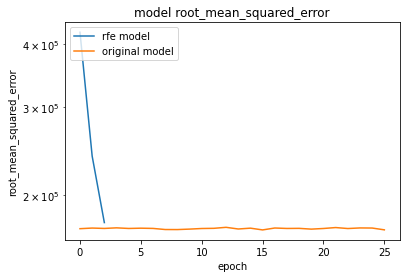

In [192]:
plt.figure(1)
plt.plot(best_model_rfe[0].history['val_root_mean_squared_error'])
plt.plot(regression_model_early_stopping[0].history['val_root_mean_squared_error'][5:])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['rfe model', 'original model'], loc='upper left')
plt.show()

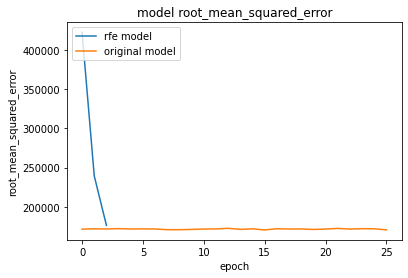

In [193]:
plt.figure(1)
plt.plot(best_model_rfe[0].history['val_root_mean_squared_error'])
plt.plot(regression_model_early_stopping[0].history['val_root_mean_squared_error'][5:])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['rfe model', 'original model'], loc='upper left')
plt.show()